# TP3 - Visión por computadora 1

Integrantes:
- Marco Joel Isidro (a1520)
- Diego Sarina (a1519)
- Julio Donadello (a1505)

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en `tp3/enunciado/images` a partir del template `tp3/enunciado/template`.

1. Obtener una detección del logo en cada imagen sin falsos positivos.
2. Plantear y validar un algoritmo para múltiples detecciones en la imagen `coco_multi.png` con el mismo template del ítem 1.
3. Generalizar el algoritmo del ítem 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [1]:
import cv2 as cv
import numpy as np

from utils.utils import *

In [2]:
# definiciones generales
image_base_path = './enunciado/images/'
image_files = ['coca_logo_1.png', 'coca_logo_2.png', 'coca_retro_1.png', 'coca_retro_2.png', 'COCA-COLA-LOGO.jpg', 'logo_1.png', 'coca_multi.png']

template_path = './enunciado/template/pattern.png'

# lista de imagenes a procesar 
images_paths = [f"{image_base_path}{image_file}" for image_file in image_files]

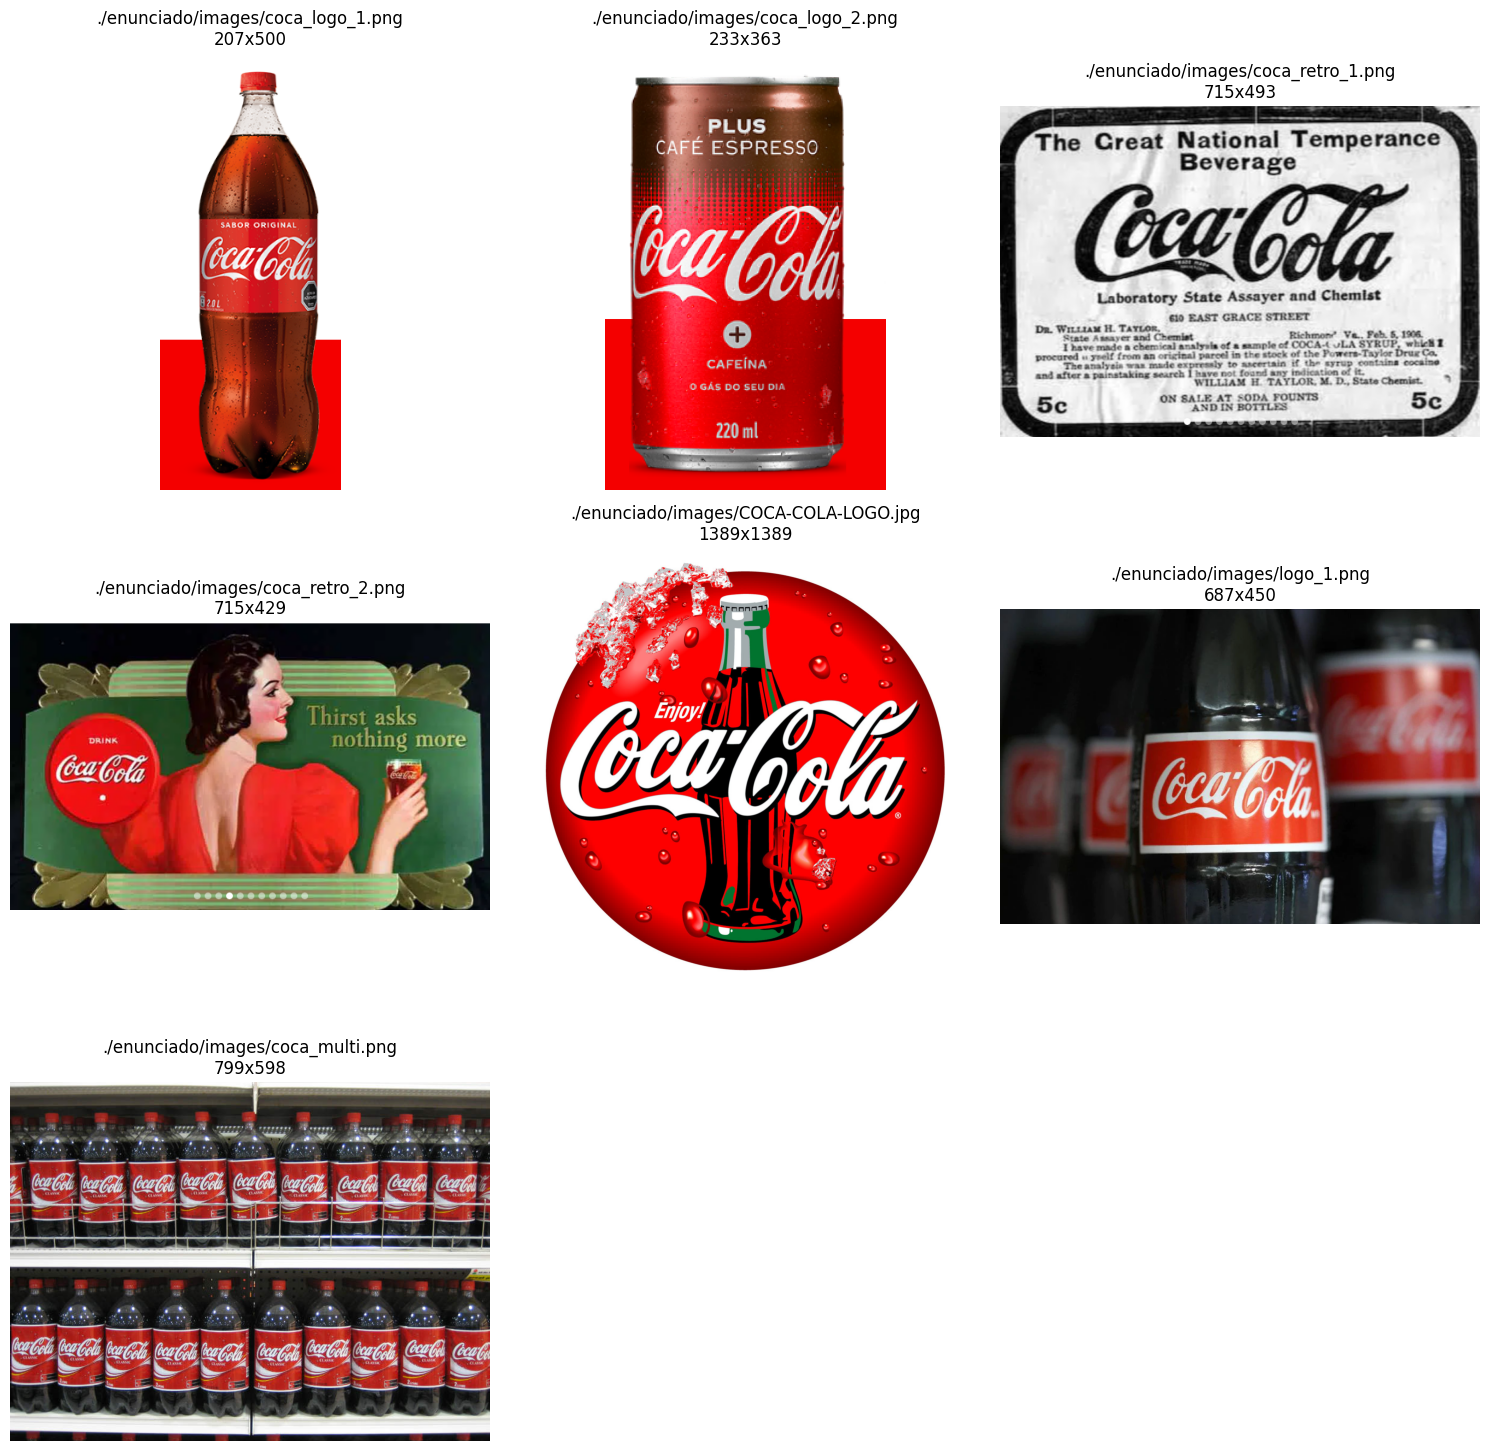

In [3]:
# Visalizo las imagenes que tengo que procesar
show_images(images_paths)

## Punto 1

Obtener una detección del logo en cada imagen sin falsos positivos.

A continuación se va a implementar el método de template matching para encontrar el logo de la gaseosa en las imágenes provistas.

Dimensiones del template: (175, 400)


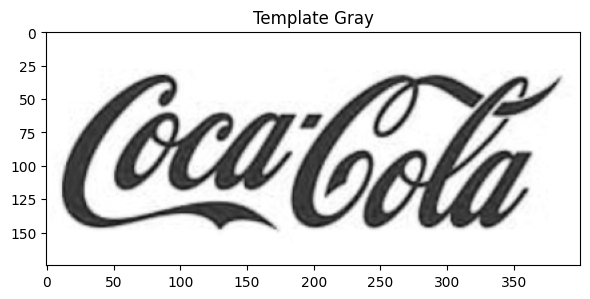

In [4]:
# Cargo el template y lo visualizo
template = cv.imread(template_path, cv.IMREAD_GRAYSCALE)
print(f"Dimensiones del template: {template.shape}")

# Visualizar el template en escala de grises
fig, axs = plt.subplots(1, 1, figsize=(6, 5))

axs.imshow(template, cmap='gray')
axs.set_title('Template Gray')

plt.tight_layout()
plt.show()

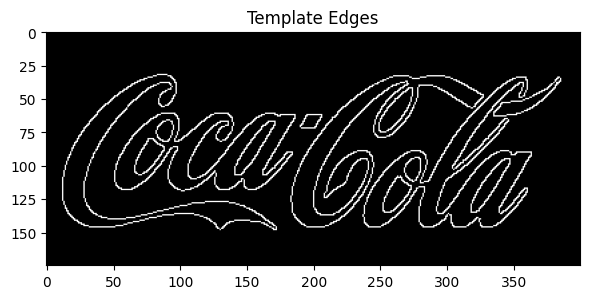

In [5]:
# aplico canny al template para detectar bordes
template_edges = cv.Canny(template, 120, 240, L2gradient=True)

# Visualizar la deteccion de bordes
fig, axs = plt.subplots(1, 1, figsize=(6, 5))

axs.imshow(template_edges, cmap='gray')
axs.set_title('Template Edges')

plt.tight_layout()
plt.show()

### Análisis exploratorio de las métricas

Entre los metodos de similitud que se van a implementar se encuentran:
- cv2.TM_CCOEFF: Correlación cruzada
- cv2.TM_CCOEFF_NORMED: Correlación cruzada normalizada
- cv2.TM_CCORR: Correlación
- cv2.TM_CCORR_NORMED: Correlación normalizada
- cv2.TM_SQDIFF: Diferencia cuadrática
- cv2.TM_SQDIFF_NORMED: Diferencia cuadrática normalizada

A partir del análisis realizado en el notebook `AnalisisExploratorio.ipynb` pudimos comprobar que la métrica que mejor resultado da, para el conjunto de imágenes con el que contabamos, fue la correlación cruzada. Por lo tanto, se va a utilizar esta métrica para realizar el template matching.

### Implementación función template matching con una imágen

A continuación se va a implementar la función `detect_one_logo_in_image` que recibe una imagen y un template y devuelve la imagen con el bounding box de la mejor detección.

In [6]:
def detect_one_logo_in_image(image: np.ndarray, template_edges: np.ndarray, method:str='cv.TM_CCOEFF', max_scale:float=4.0):
    # convierto la imagen de entrada a escala de grises 
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    # defino los umbrales para crear la escala.
    min_scale = max(template_edges.shape[0] / gray_image.shape[0], template_edges.shape[1] / gray_image.shape[1])
    scale_factors = np.linspace(min_scale, max_scale, 100)

    best_resultado = []

    for scale in scale_factors:
        # escalo la imagen (si se hace en el template se pierde definicion)
        scaled_image = cv.resize(gray_image, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
        scaled_edges = cv.Canny(scaled_image, 100, 200, L2gradient=True)
    
        # calculo la correlacion
        correlation_result = cv.matchTemplate(scaled_edges, template_edges, eval(method))
        _, best_match_value, _, best_match_location = cv.minMaxLoc(correlation_result)
    
        if best_resultado == [] or best_match_value > best_resultado[0]:
            best_resultado = [best_match_value, best_match_location, (template_edges.shape), scale]
        
    image_graf = graf_boxplot(image, best_resultado)

    #grafico la imagen con el logo detectado
    fig, axs = plt.subplots(1, 1, figsize=(6, 5))

    axs.imshow(cv.cvtColor(image_graf, cv.COLOR_BGR2RGB))
    axs.set_title(f'Logo Detectado con metrica: {method} y valor: {best_resultado[0]:.2f}')
    axs.axis('off')

    plt.tight_layout()
    plt.show()

Analisis sobre la imagen ./enunciado/images/coca_logo_1.png: 


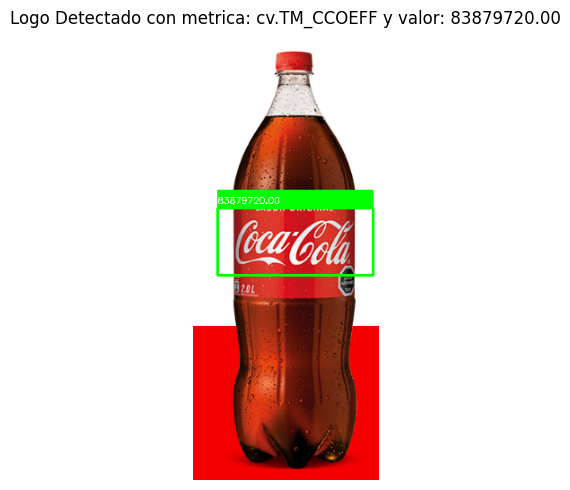

Analisis sobre la imagen ./enunciado/images/coca_logo_2.png: 


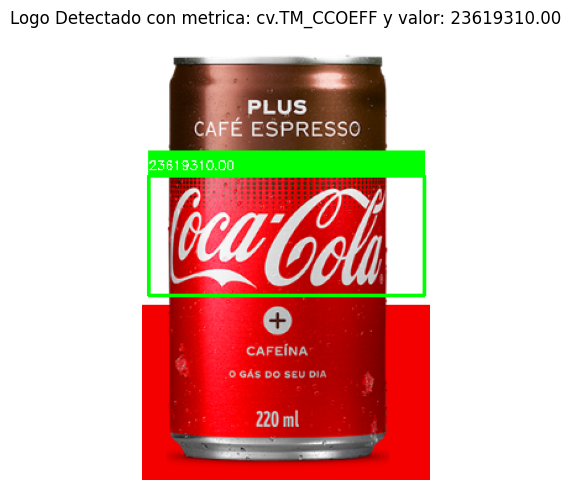

Analisis sobre la imagen ./enunciado/images/coca_retro_1.png: 


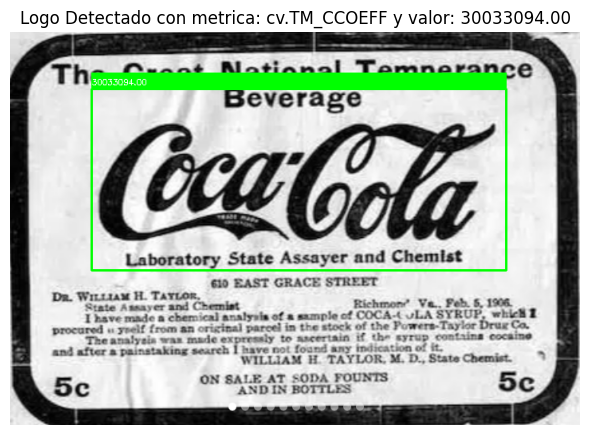

Analisis sobre la imagen ./enunciado/images/coca_retro_2.png: 


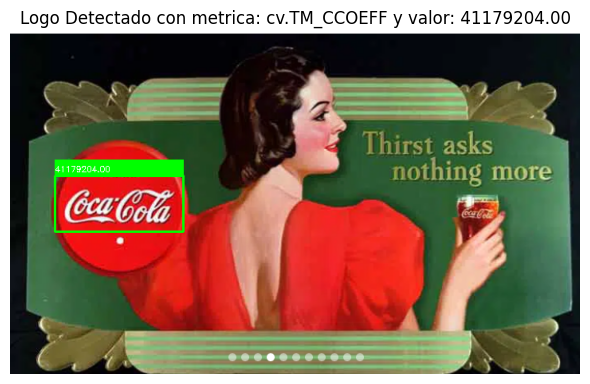

Analisis sobre la imagen ./enunciado/images/COCA-COLA-LOGO.jpg: 


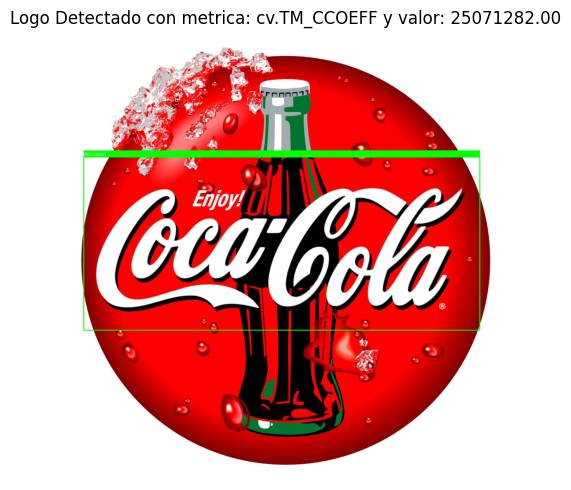

Analisis sobre la imagen ./enunciado/images/logo_1.png: 


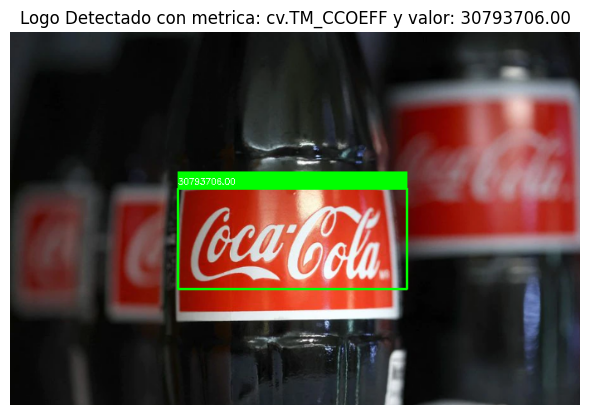

Analisis sobre la imagen ./enunciado/images/coca_multi.png: 


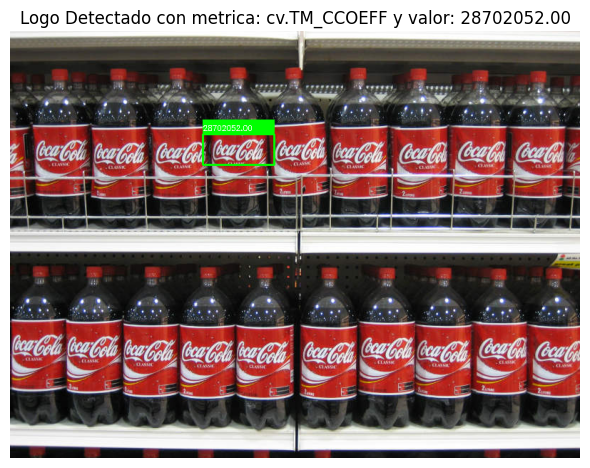

In [7]:
for image in images_paths:
    print(f"Analisis sobre la imagen {image}: ")
    detect_one_logo_in_image(cv.imread(image), template_edges)

## Punto 2 y 3

2. Plantear y validar un algoritmo para múltiples detecciones en la imagen `coco_multi.png` con el mismo template del ítem 1.
3. Generalizar el algoritmo del ítem 2 para todas las imágenes.

A continuación se va a implementar la función `detect_all_logos_in_image` que recibe una imagen y un template y devuelve la imagen con los bounding boxes de todas las detecciones.

In [8]:
def detect_multi_logo_in_image(image: np.ndarray, template_edges: np.ndarray, match_threshold:float=0.5, method:str='cv.TM_CCOEFF', max_scale:float=4.0):
    """
    Funcion que detecta multiples logos en una imagen y devuelve las coincidencias.

    Args:
        image: imagen en la que se busca el logo
        template_edges: bordes del template
        match_threshold: umbral de coincidencia
        method: metodo de correlacion
        max_scale: maximo factor de escala

    Returns:
        coincidences: lista de coincidencias
    """
    # convierto la imagen de entrada a escala de grises 
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # defino los umbrales para crear la escala.
    # defino un maximo y luego se generan el minimo
    min_scale = max (template_edges.shape[0] / gray_image.shape[0], template_edges.shape[1] / gray_image.shape[1])
    scale_factors = np.linspace(min_scale, max_scale, 100)

    coincidences_best_scaled = []
    
    for scale in scale_factors:
        coincidences = []
        # escalo la imagen (si lo hago en el template pierdo definicion)
        scaled_image = cv.resize(gray_image, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR) #buscar inter_linear
        scaled_edges = cv.Canny(scaled_image, 100, 200, L2gradient=True)
        
        # calculo la correlacion
        correlation_result = cv.matchTemplate(scaled_edges, template_edges, eval(method))
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(correlation_result)
        width, height = template_edges.shape[::-1]

        locations = np.where(correlation_result >= match_threshold * max_val)
        for loc in zip(*locations[::-1]):
            coincidences.append((correlation_result[loc[1], loc[0]], loc, template_edges.shape, scale))
        
        if coincidences_best_scaled == [] or (max(coincidences, key=lambda x: x[0])[0] > max(coincidences_best_scaled, key=lambda x: x[0])[0]):
            coincidences_best_scaled = coincidences

    # busco la coincidencia óptima (con el puntaje más alto)
    optimal_match = max(coincidences_best_scaled, key=lambda x: x[0])

    # filtro las coincidencias que cumplan con el umbral de coincidencia
    filtered_coincidences = []
    for match in coincidences_best_scaled:
        if match[0] >= match_threshold * optimal_match[0]:
            filtered_coincidences.append(match)

    # ordeno las coincidencias filtradas por puntaje de mayor a menor
    filtered_coincidences.sort(key=lambda x: x[0], reverse=True)

    # eliminar superposiciones
    filtered_coincidences = remove_overlaps(filtered_coincidences)
    
    image_graf = graf_multi_boxplot(image, filtered_coincidences)

    #grafico la imagen con el logo detectado
    fig, axs = plt.subplots(1, 1, figsize=(6, 5))

    axs.imshow(cv.cvtColor(image_graf, cv.COLOR_BGR2RGB))
    axs.set_title(f'Logos Detectados con metrica: {method}')
    axs.axis('off')

    plt.tight_layout()
    plt.show()

    return filtered_coincidences

Analisis sobre la imagen ./enunciado/images/coca_logo_1.png: 


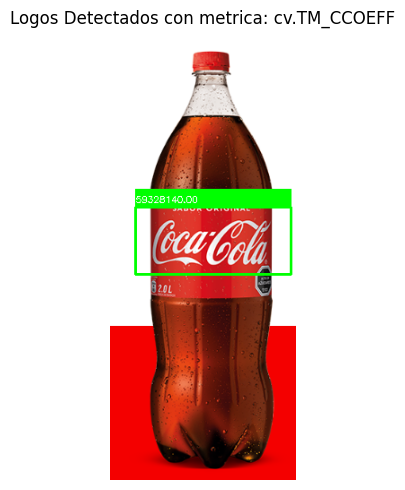

Analisis sobre la imagen ./enunciado/images/coca_logo_2.png: 


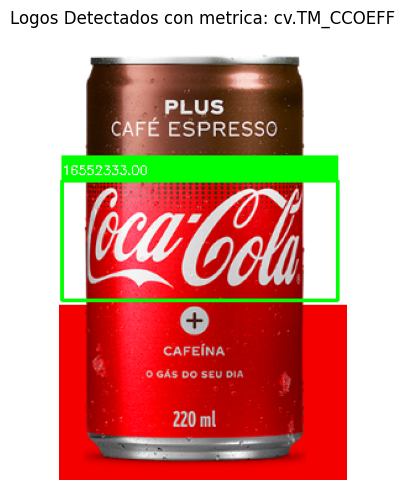

Analisis sobre la imagen ./enunciado/images/coca_retro_1.png: 


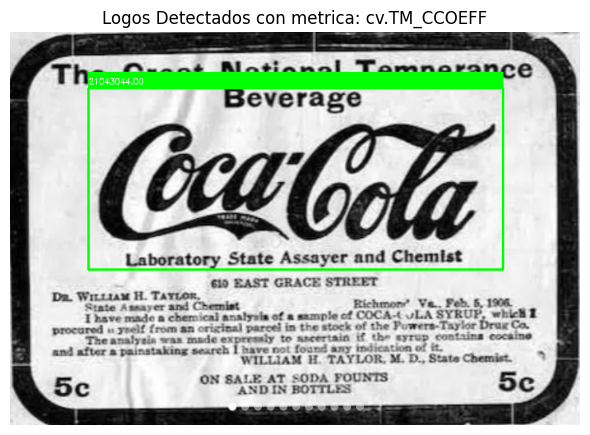

Analisis sobre la imagen ./enunciado/images/coca_retro_2.png: 


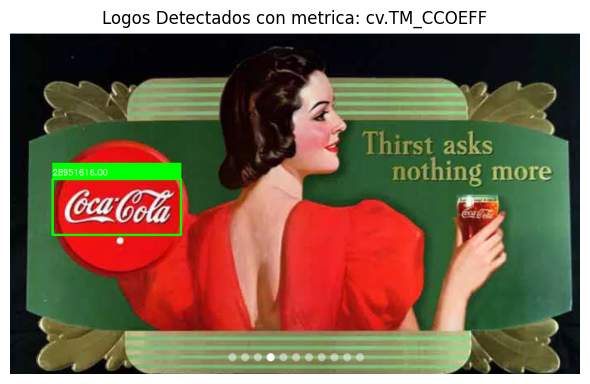

Analisis sobre la imagen ./enunciado/images/COCA-COLA-LOGO.jpg: 


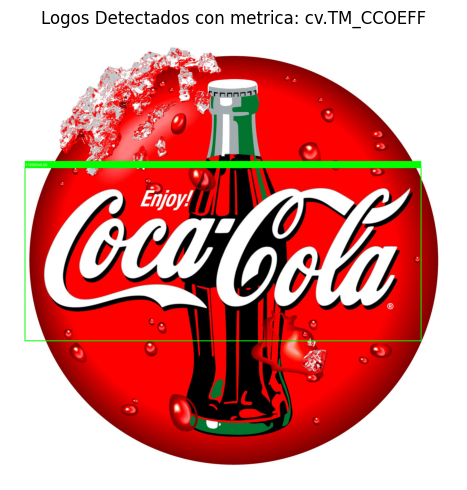

Analisis sobre la imagen ./enunciado/images/logo_1.png: 


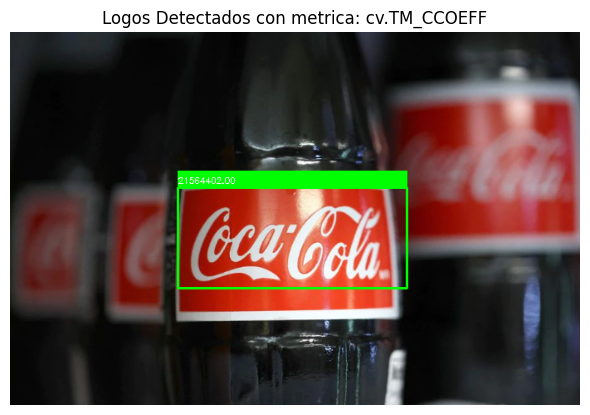

Analisis sobre la imagen ./enunciado/images/coca_multi.png: 


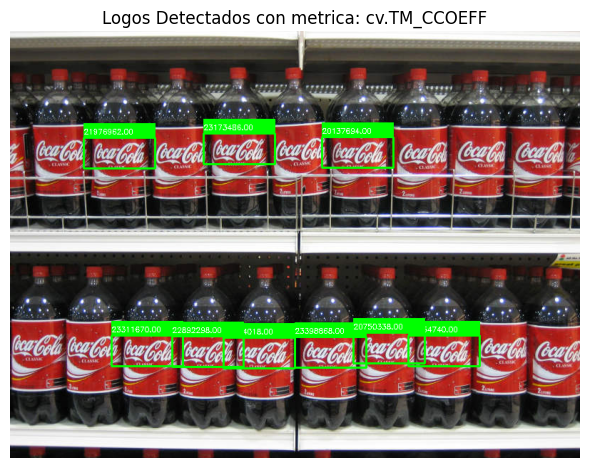

In [9]:
for image in images_paths:
    print(f"Analisis sobre la imagen {image}: ")
    detect_multi_logo_in_image(cv.imread(image), template_edges, match_threshold=0.7)